# Roberta Binary Classification

### Links

https://towardsdatascience.com/fine-tuning-bert-and-roberta-for-high-accuracy-text-classification-in-pytorch-c9e63cf64646 
https://huggingface.co/docs/transformers/en/perf_torch_compile (can be used on GPU , dependency : visual basic C++ tools)

In [1]:
#importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import spacy ## Preprocessing
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import re ## Preprocessing
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
#from torchtext import data
#from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator
from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cpu')
tokenizer = RobertaTokenizer.from_pretrained(r"\\rsc.humad.com\rdrive\FinRec\FRSolutions\FRS Reporting\RXS Information\Financial Reporting\Forecast Research Dashboard\Data Science\Member_grievance\Abhirup\Model\roberta-base",return_dict=False)
output_path=r"C:\Users\KPA2877\Documents\Model (10)\Split_No-Split"
data_path=r"C:\Users\KPA2877\Documents\Model (10)\Split_No-Split"

In [2]:
#!pip install spacy

In [3]:
df=pd.read_excel(r"DATA.xlsx")

In [4]:
df.head(5)

Sentence  Tag
0  qaa details documented verbal consent obtained...    1
1  apologized to mrs robinson and i would submit ...    1
2  griev documented is sharing that the griev 042...    1
3  qaa details documented qaa template completed ...    1
4  appeal details cancellation fees times at leas...    1

In [5]:
#df['Tag'] = df['Tag'].map({'Expedite': 1, 'Non Expedite': 0})

# Filling NaN values with a default integer value, e.g., -1
#df['Tag'] = df['Tag'].fillna(-1)
# Remove rows with NaN values in 'Tag' column
df = df.dropna(subset=['Tag'])
# Convert 'Tag' column to integers
df['Tag'] = df['Tag'].astype(int)

In [6]:
df['Tag'].value_counts()

Tag
0    910
1    155
Name: count, dtype: int64

In [7]:
# Function to preprocess the data
nlp = spacy.load("en_core_web_lg")
def process_sentence(sentence):
    
    doc = nlp(sentence)  # Process the sentence with SpaCy
    cleaned_tokens = []   # Initialize an empty list to store modified tokens
    for token in doc:
        # Check if the token is not a name, organization, or location
        if token.ent_type_ not in ['PERSON', 'ORG', 'GPE']:
            # If not, add the token text to the cleaned_tokens list
            cleaned_tokens.append(token.text)
    cleaned_sentence = ' '.join(cleaned_tokens)  # Join the cleaned tokens back into a string
    return cleaned_sentence

def preprocess_text(text):
    # Converting text to lowercase
    text = text.lower()
    # Removing extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Removing hyperlinks
    text = re.sub(r'<a\s+(?:[^>]*?\s+)?href=(["\'])(.*?)\1[^>]*>(.*?)</a>', r'\3', text)
    # Removing noise and special characters (retain alpha-numeric and basic punctuation)
    text = re.sub(r"[^a-zA-Z0-9\s.,!?-]", "", text)
    text = text.strip()
    # Apply SpaCy processing to the text
    cleaned_text = process_sentence(text)
   
    return cleaned_text
    

In [8]:
df['Sentence'] = df['Sentence'].apply(preprocess_text)

In [9]:
df.to_csv(r"C:\Users\KPA2877\Documents\Model (10)\Split_No-Split\Content_Train_Data.csv")

In [10]:
df.shape

(1065, 2)

In [11]:
df.head()

Sentence  Tag
0  qaa details documented verbal consent obtained...    1
1  apologized to mrs robinson and i would submit ...    1
2  griev documented is sharing that the griev 042...    1
3  qaa details documented qaa template completed ...    1
4  appeal details cancellation fees times at leas...    1

# Training

In [12]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=3, mode="max"):
        self.patience = patience
        self.mode = mode
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, score):
        if self.best_score is None or (
            self.mode == "max" and score > self.best_score
        ) or (self.mode == "min" and score < self.best_score):
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Initializing early stopping
early_stopping = EarlyStopping(patience=3, mode="min")

In [13]:
# Model with extra layers on top of RoBERTa with self-attention mechanism
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.2):  # Changed dropout rate to 0.2 from 0.3
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained(r"\\rsc.humad.com\rdrive\FinRec\FRSolutions\FRS Reporting\RXS Information\Financial Reporting\Forecast Research Dashboard\Data Science\Member_grievance\Abhirup\Model\roberta-base")
        self.attention = torch.nn.MultiheadAttention(embed_dim=768, num_heads=8)
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 2)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        
        # Adding sequence dimension for self-attention
        x = x.unsqueeze(1)
        
        # Applying self-attention
        x, _ = self.attention(x, x, x)
        
        # Removing sequence dimension
        x = x.squeeze(1)
        
        # Applying dropout, linear transformation, and layer normalization
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        
        # Applying ReLU activation
        x = torch.nn.ReLU()(x)
        
        # Applying second dropout and linear transformation
        x = self.d2(x)
        x = self.l2(x)
        
        return x 

In [14]:
# Set tokenizer hyperparameters.
MAX_SEQ_LEN = 128
BATCH_SIZE = 32 ## Training data is more hence the batch size is 32
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
# Define columns to read.
label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)

fields = {'Sentence' : ('Sentence', text_field), 'Tag' : ('Tag', label_field)}

# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
train_data, valid_data, test_data = TabularDataset(path=f"{data_path}/Content_Train_Data.csv", 
                                                   format='csv',
                                                   fields=fields, 
                                                   skip_header=False).split(split_ratio=[0.70, 0.20, 0.10], 
                                                                            stratified=True, 
                                                                            strata_field='Tag')


                                                                            

# Create train and validation iterators.
train_iter, valid_iter = BucketIterator.splits((train_data, valid_data),
                                               batch_size=BATCH_SIZE,
                                               device=device,
                                               shuffle=True,
                                               sort_key=lambda x: len(x.Sentence), 
                                               sort=True, 
                                               sort_within_batch=False)

# Test iterator, no shuffling or sorting required.
test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)


In [15]:
df.head()

Sentence  Tag
0  qaa details documented verbal consent obtained...    1
1  apologized to mrs robinson and i would submit ...    1
2  griev documented is sharing that the griev 042...    1
3  qaa details documented qaa template completed ...    1
4  appeal details cancellation fees times at leas...    1

In [16]:
# Functions for saving and loading model parameters and metrics.
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict6': model.state_dict(),
                  'valid_loss': valid_loss}, path)
        
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict6'])
    return state_dict['valid_loss']

def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    torch.save(state_dict, path)

def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [17]:
def pretrain(model, 
             optimizer, 
             train_iter, 
             valid_iter, 
             scheduler = None,
             valid_period = len(train_iter),
             num_epochs = 5):
    
    # Pretrain linear layers, do not train bert
    for param in model.roberta.parameters():
        param.requires_grad = False
    
    model.train()
    
    # Initializing losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0   
    global_step = 0  
    
    # Training loop
    for epoch in range(num_epochs):
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)
            
            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
   
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Updating train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)
                        
                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        
                        valid_loss += loss.item()

                # Storing train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                
                model.train()

                # printing summary
                print('Epoch [{}/{}], global step [{}/{}], PT Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                train_loss = 0.0                
                valid_loss = 0.0
    
    # Seting bert parameters back to trainable
    for param in model.roberta.parameters():
        param.requires_grad = True
        
    print('Pre-training done!')

In [18]:
# Training Function
def train(model,
          optimizer,
          train_iter,
          valid_iter,
          scheduler=None,
          num_epochs=5,
          valid_period=len(train_iter),
          output_path=output_path):
    
    train_loss = 0.0
    valid_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')
    
    global_step = 0
    global_steps_list = []
    
    model.train()
    
    for epoch in range(num_epochs):
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)

            y_pred = model(input_ids=source, attention_mask=mask)
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
            loss.backward()
            
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            
            train_loss += loss.item()
            global_step += 1

            if global_step % valid_period == 0:
                model.eval()
                valid_preds = []
                valid_labels = []
                
                with torch.no_grad():
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)
                        y_pred = model(input_ids=source, attention_mask=mask)
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        valid_loss += loss.item()
                        
                        valid_preds.extend(torch.argmax(y_pred, dim=1).cpu().numpy())
                        valid_labels.extend(target.cpu().numpy())

                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)

                accuracy = accuracy_score(valid_labels, valid_preds)
                precision, recall, f1, _ = precision_recall_fscore_support(valid_labels, valid_preds, average='binary')

                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{global_step}/{num_epochs*len(train_iter)}], '
                      f'Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, '
                      f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, '
                      f'Recall: {recall:.4f}, F1: {f1:.4f}')
                
                if best_valid_loss > valid_loss:
                    best_valid_loss = valid_loss
                    save_checkpoint(output_path + '/model6.pkl', model, best_valid_loss)
                    save_metrics(output_path + '/metric6.pkl', train_loss_list, valid_loss_list, global_steps_list)
                        
                train_loss = 0.0                
                valid_loss = 0.0
                model.train()
                # Checking early stopping
                early_stopping(valid_loss)
                if early_stopping.early_stop:
                    print("Early stopping")
                    break
    
    save_metrics(output_path + '/metric6.pkl', train_loss_list, valid_loss_list, global_steps_list)
    print('Training done!')

In [19]:
# Main training loop
NUM_EPOCHS = 6
steps_per_epoch = len(train_iter)

model = ROBERTAClassifier(0.2)
model = model.to(device)


optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

print("======================= Start pretraining ==============================")

pretrain(model=model,
         train_iter=train_iter,
         valid_iter=valid_iter,
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

NUM_EPOCHS = 200
print("======================= Start training =================================")
optimizer = AdamW(model.parameters(), lr=2e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

train(model=model, 
      train_iter=train_iter, 
      valid_iter=valid_iter, 
      optimizer=optimizer, 
      scheduler=scheduler, 
      num_epochs=NUM_EPOCHS)

Some weights of RobertaModel were not initialized from the model checkpoint at \\rsc.humad.com\rdrive\FinRec\FRSolutions\FRS Reporting\RXS Information\Financial Reporting\Forecast Research Dashboard\Data Science\Member_grievance\Abhirup\Model\roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


======================= Start pretraining ==============================
Epoch [1/6], global step [24/144], PT Loss: 0.4896, Val Loss: 0.5394
Epoch [2/6], global step [48/144], PT Loss: 0.4358, Val Loss: 0.5315
Epoch [3/6], global step [72/144], PT Loss: 0.4288, Val Loss: 0.5309
Epoch [4/6], global step [96/144], PT Loss: 0.4241, Val Loss: 0.5310
Epoch [5/6], global step [120/144], PT Loss: 0.4269, Val Loss: 0.5354
Epoch [6/6], global step [144/144], PT Loss: 0.4232, Val Loss: 0.5371
Pre-training done!
======================= Start training =================================
Epoch [1/200], Step [24/4800], Train Loss: 0.4293, Valid Loss: 0.5372, Accuracy: 0.8505, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch [2/200], Step [48/4800], Train Loss: 0.4330, Valid Loss: 0.5364, Accuracy: 0.8505, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch [3/200], Step [72/4800], Train Loss: 0.4281, Valid Loss: 0.5349, Accuracy: 0.8505, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch [4/200],

In [ ]:
Epoch [100/100], Step [2000/2000], Train Loss: 0.0985, Valid Loss: 0.1585, Accuracy: 0.9560, Precision: 0.8000, Recall: 0.8000, F1: 0.8000
Early stopping

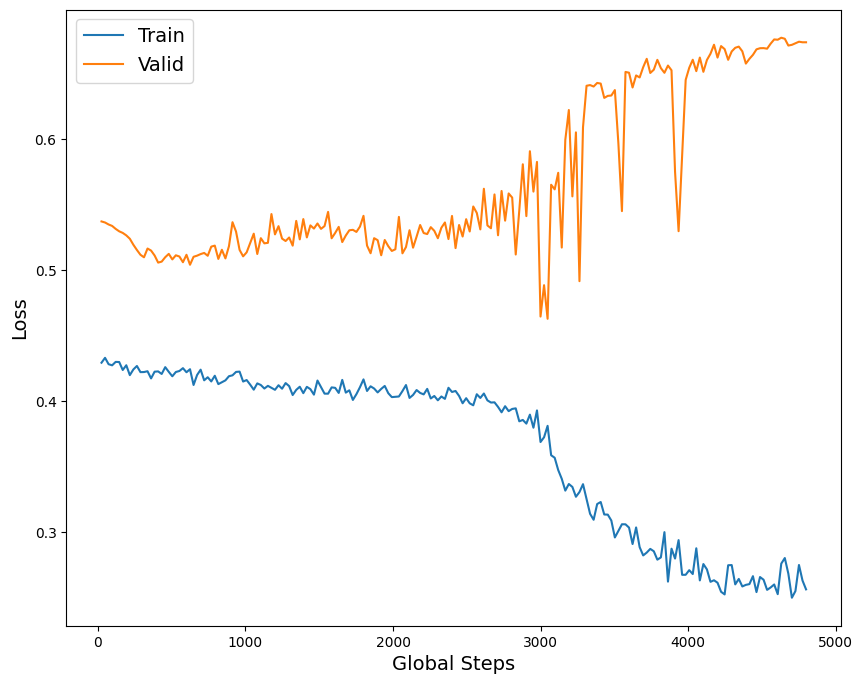

In [20]:
plt.figure(figsize=(10, 8))
train_loss_list, valid_loss_list, global_steps_list = load_metrics(output_path + '/metric6.pkl')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show() 

# Evaluation

In [21]:
# Evaluation Function
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (source, target), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, attention_mask=mask)

                y_pred.extend(torch.argmax(output, axis=-1).tolist())
                y_true.extend(target.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[0,1], digits=4))
    #cm=confusion_matrix(y_true, y_pred)
    
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])

Some weights of RobertaModel were not initialized from the model checkpoint at \\rsc.humad.com\rdrive\FinRec\FRSolutions\FRS Reporting\RXS Information\Financial Reporting\Forecast Research Dashboard\Data Science\Member_grievance\Abhirup\Model\roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classification Report:
              precision    recall  f1-score   support

           0     0.8545    1.0000    0.9215       182
           1     0.0000    0.0000    0.0000        31

    accuracy                         0.8545       213
   macro avg     0.4272    0.5000    0.4608       213
weighted avg     0.7301    0.8545    0.7874       213



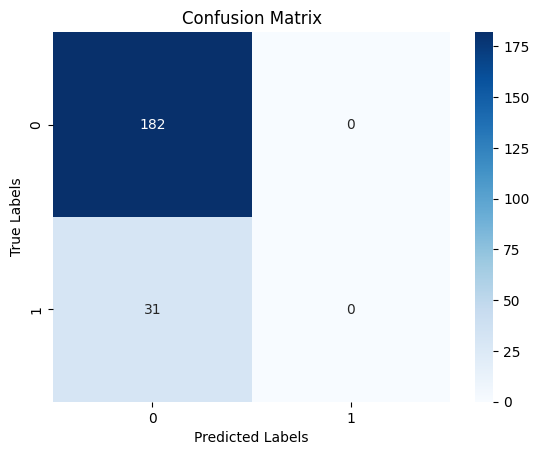

In [22]:
model = ROBERTAClassifier()
model = model.to(device)
load_checkpoint(output_path + '/model6.pkl', model)
evaluate(model, test_iter)

Some weights of RobertaModel were not initialized from the model checkpoint at \\rsc.humad.com\rdrive\FinRec\FRSolutions\FRS Reporting\RXS Information\Financial Reporting\Forecast Research Dashboard\Data Science\Member_grievance\Abhirup\Model\roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classification Report:
              precision    recall  f1-score   support

           0     0.8505    1.0000    0.9192        91
           1     0.0000    0.0000    0.0000        16

    accuracy                         0.8505       107
   macro avg     0.4252    0.5000    0.4596       107
weighted avg     0.7233    0.8505    0.7817       107



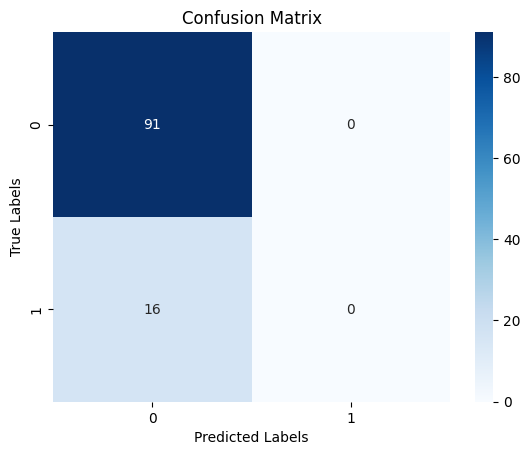

In [23]:
model = ROBERTAClassifier()
model = model.to(device)
load_checkpoint(output_path + '/model6.pkl', model)
evaluate(model, valid_iter)

## Prediction for unknown data

In [24]:
### 1. Class Prediction for Sentences in Excel File

import pandas as pd
import torch
from transformers import RobertaTokenizer

# Load the trained model
model_path = r"C:\Users\SHS5222\GNA_Trial\model6.pkl"
model = ROBERTAClassifier()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))['model_state_dict6'])
model.eval()

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Load the Excel file
input_file = r"G&A_class_prediction.xlsx"
df = pd.read_excel(input_file)

# Preprocess the sentences
def process_sentence(sentence):
    
    doc = nlp(sentence)  # Process the sentence with SpaCy
    cleaned_tokens = []   # Initialize an empty list to store modified tokens
    for token in doc:
        # Check if the token is not a name, organization, or location
        if token.ent_type_ not in ['PERSON', 'ORG', 'GPE']:
            # If not, add the token text to the cleaned_tokens list
            cleaned_tokens.append(token.text)
    cleaned_sentence = ' '.join(cleaned_tokens)  # Join the cleaned tokens back into a string
    return cleaned_sentence
   
   
def preprocess_text(text):
# Convert text to lowercase and strip whitespace
    text = text.lower().strip()
    # Remove hyperlinks
    text = re.sub(r'<a\s+(?:[^>]*?\s+)?href=(["\'])(.*?)\1[^>]*>(.*?)</a>', r'\3', text)
    # Remove special characters
    text = re.sub(r'[^a-zA-Z ]', '', text)   
    text=text.strip()
    # Apply SpaCy processing to the text
    cleaned_text = process_sentence(text)
   
    return cleaned_text

df['Sentence'] = df['Sentence'].apply(preprocess_text)

# Tokenize and predict
def predict(sentence):
    inputs = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=128,
        pad_to_max_length=True,
        return_tensors='pt'
    )
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, prediction = torch.max(outputs, dim=1)
    
    return "Expedite" if prediction.item() == 1 else "Non Expedite"

df['Prediction'] = df['Sentence'].apply(predict)
df.to_excel(r"Roberta_predictions60.xlsx", index=False)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
### 1. Load the Trained Model and Tokenizer

import pandas as pd
import torch
from transformers import RobertaTokenizer

# Load the trained model
model_path = r"C:\Users\SHS5222\GNA_Trial\model.pkl"
model = ROBERTAClassifier()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))['model_state_dict'])
model.eval()

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

### 2. Preprocess the Sentences

import re
import spacy

nlp = spacy.load("en_core_web_lg")

def process_sentence(sentence):
    doc = nlp(sentence)
    cleaned_tokens = [token.text for token in doc if token.ent_type_ not in ['PERSON', 'ORG', 'GPE']]
    return ' '.join(cleaned_tokens)

def preprocess_text(text):
    text = text.lower().strip()
    text = re.sub(r'<a\s+(?:[^>]*?\s+)?href=(["\'])(.*?)\1[^>]*>(.*?)</a>', r'\3', text)
    text = re.sub(r'[^a-zA-Z ]', '', text)
    return process_sentence(text)

### 3. Define the Prediction Function

def predict(sentence):
    inputs = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=128,
        pad_to_max_length=True,
        return_tensors='pt'
    )
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, prediction = torch.max(outputs, dim=1)
    
    return prediction.item()

### 4. Create the Pipeline to Process the Excel File

# Load the Excel file
input_file = r"path_to_your_excel_file.xlsx"
df = pd.read_excel(input_file)

# Preprocess the sentences
df['Sentence'] = df['Sentence'].apply(preprocess_text)

# Predict the class for each sentence
df['Prediction'] = df['Sentence'].apply(predict)

# Save the predictions to a new Excel file
df.to_excel(r"path_to_save_predictions.xlsx", index=False)

# Inference

In [ ]:
# Model with extra layers on top of RoBERTa
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 5)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask,return_dict=False)
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        
        return x  

In [ ]:
t1=time.time()
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])   
    return model,state_dict['valid_loss']

model = ROBERTAClassifier()
model = model.to(device)
saved_model_path = output_path + '/model.pkl'  # Adjust this according to your setup
loaded_model, _ = load_checkpoint(saved_model_path,model)

# Load pre-trained model tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
t2=time.time()
t2-t1

In [ ]:
txt=pd.read_excel(r"C:\RSS\jyothi\classification\train_data_03_04_24.xlsx")
sentences=list(txt['sentences'])

In [ ]:
sentences

In [ ]:
# Define a function to predict sentences in batches
def predict_sentences_batch(model, tokenizer, sentences, batch_size=32):
    predicted_labels = []
    dataloader = DataLoader(sentences, batch_size=batch_size)

    for batch in dataloader:
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        predicted_labels.extend(torch.argmax(outputs, dim=-1).tolist())
    return predicted_labels

t1 = time.time()
predicted_labels = predict_sentences_batch(loaded_model, tokenizer, sentences)
t2 = time.time()
print("Time taken:", t2 - t1)

In [ ]:
#avg time / sentence
(t2-t1)/950

In [ ]:
len(predicted_labels)